In [1]:
import pandas as pd
pd.set_option('display.max_columns', 40)
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, SGDRegressor

import matplotlib.pyplot as plt

# Hong Kong horse race prediction models

This notebook runs through various models which will predict the outcome of horse races in Hong Kong. Different types of models will be trained, along with different hyperparameters, in order to produce the best possible model. The best model and its hyperparameters will then be saved as a separate python script, which will allow us to easily pass new data through and make predictions.

## Notebook Overview

<font size = 4>

1. Loading and splitting dataset 
    
2. Data preprocessing for ML models
    - 2.1 Creating new variables
    - 2.2 Separate test and training set
    - 2.3 Visualizing relationships

    
3. Fitting models
    - 3.1 Linear regression
    
4. Results

## 1. Loading and splitting dataset

The data set being used here is the _Hong Kong horse racing_ dataset. Please see the EDA.ipynb file (in the src directory) and README for a more in depth description of this dataset.

In [2]:
training_data = pd.read_csv("../data/data_train.csv")
training_data.head()

,Unnamed: 0,row,plc,horseno,horse,jockey,trainer_x,actualwt,declarwt,draw,lbw,runningpos,finishtime,winodds,date,raceno,class,distance,going,handicap,course,stake,venue,dataset,gear,comment,result,country,colour,sex,owner,import_type,current_rating,start_rating,sire,dam,age
0,21818,NaN,3,NaN,SPICY KAKA(V323),K Teetan,J Moore,NaN,NaN,2.0,2-1/2L,2 2 3,1.11.40,NaN,2016-07-05,1,NaN,1200,WET,NaN,ALL WEATHER TRACK,NaN,SHA TIN,barrier,B,Slow to begin; raced greenly.,Passed,GB,Bay,Gelding,Kathleen Shi Pui Ka,ISG,57.0,51.0,Excellent Art,Cheap Thrills,5.0
1,7569,6.0,7,9.0,DIAMOND MASTER(S397),K C Leung,P F Yiu,116.0,1156.0,8.0,4-1/2,3 2 7,1.09.61,39.0,2016-04-16,8,3.0,1200,GOOD TO FIRM,THE SPORTS WITHOUT BORDERS HANDICAP,TURF - C+3 COURSE,1165000.0,Sha Tin,results,B/XB,"In pursuit of leader, held 2nd till 250M, no e...",NaN,AUS,Bay,Gelding,HK Diamond Bourse Racing Syndicate,PPG,68.0,69.0,Not A Single Doubt,Sandy Desert,6.0
2,12339,11.0,12,5.0,TARZAN I AM(P299),C Y Ho,D Cruz,125.0,1224.0,14.0,12,6 9 12,1.11.19,21.0,2015-06-14,3,4.0,1200,GOOD TO FIRM,CARL F. BUCHERER HANDICAP,TURF - B+2 COURSE,760000.0,Sha Tin,results,TT,"Camped handy, however trapped 4 wide without c...",NaN,NZ,Bay,Gelding,Fok Yuk Tong,PP,NaN,NaN,Darci Brahma,Climb The Vine,NaN
3,12719,11.0,12,4.0,AIMING HIGH(V206),M L Yeung,T P Yung,124.0,1149.0,8.0,19,11 11 12,1.13.11,32.0,2016-04-13,6,3.0,1200,GOOD TO YIELDING,MATHESON HANDICAP,TURF - A COURSE,1165000.0,Happy Valley,results,H,"At rear throughout, never in contention. ...",NaN,NZ,Bay,Gelding,"Terence Leung Chi Kin, Patrick Wong Man Kam, J...",PP,NaN,NaN,Captain Rio,Kiwi Supreme,NaN
4,8117,7.0,8,6.0,PLANET STAR(A049),S de Sousa,P O'Sullivan,125.0,1182.0,6.0,5-1/2,7 8 8,1.10.70,7.7,2017-01-14,3,4.0,1200,GOOD,HO SHEUNG HEUNG HANDICAP,TURF - C+3 COURSE,840000.0,Sha Tin,results,--,"Raced midfield, 6Ls behind the leader 3 wide w...",NaN,AUS,Brown,Gelding,Planet Racing Syndicate,PPG,50.0,52.0,Denman,Tell Someone,4.0


Before we split, we want to drop all rows which don't have a finishtime, since we need targets to train our models. We will use the `time_parser` function below to convert time string to seconds.

In [3]:
def time_parser(input_time):
    """
    Function which converts a time string of form mm.ss.SS to seconds
    
    Arguments:
    input_time (str) - input time as string of form "d.dd.dd" where d is a digit

    Returns:
    float representing input time in seconds
    """
    
    parsed_time = input_time.split(".")
    mins = int(parsed_time[0])
    secs = int(parsed_time[1])
    ss = int(parsed_time[2])
    
    time_in_sec = mins*60.0 + secs + ss/100
    return time_in_sec

In [4]:
targets = training_data["finishtime"]
#fill nans with "0.00.00"
targets.fillna("0.00.00", inplace=True)       
#replace anything not of format d.dd.dd to "0.00.00"
targets[~targets.str.contains("\d\.\d{2}\.\d{2}")] = '0.00.00'
#apply time_parser on all values
targets = np.array(list(map(lambda x: time_parser(x), targets)))
#replace target column with converted values
training_data["finishtime"] = targets
#drop all rows where finishtime is 0.0
training_data = training_data[training_data["finishtime"] != 0.0]

/Users/robertblumberg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [10]:
X_train, X_test, y_train, y_test = train_test_split(training_data.drop("finishtime", axis=1), training_data["finishtime"], test_size=0.2)

## 2. Data preprocessing

Here, we make pipeline to process the numeric and categorical features.

The numeric features will be processed by replacing nan's with the mean value of that feature. this will be done using `SimpleImputer`. The features will also be transformed to a 5^th degree polynomial, so that when we eventually fit the model, we can implement a feature selection algorithm which will choose the best features, both original and transformed.

The categorical features will be processed by replacing nan's with "not_specified". They will also be one-hot encoded.

At the end, we combine the two preprocessing pipelines.

In [11]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

#define preprocessor for numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('poly', PolynomialFeatures(degree=5))
                                     ])

#define preprocessor for categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="not_specified")),
                                          ('one_hot_encoder',  OneHotEncoder())
                                         ])

#combine numeric and categorical pipelines
categorical_features = ["country", "dataset"]
numeric_features = ["declarwt", "age", "winodds", "stake", "distance"]

preprocessing = ColumnTransformer(
                                 transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ('cat', categorical_transformer, categorical_features)
                                ])

#combine preprocessing and model fitting steps into one pipeline 
full_pipeline = Pipeline([
    ('data_preprocessing', preprocessing),
])

X_train_preprocessed = full_pipeline.fit_transform(X_train)
X_test_preprocessed = full_pipeline.transform(X_test)

## 3. Fitting models

### 3.1 Linear regression

#### 3.1.1 Feature selection

First, we will optimize the number of features to select using grid search.

In [12]:
param_grid = [{
    "n_features_to_select" : [10, 12, 15, 18, 20, 22, 25, 28, 30]
}]
gridsearch = GridSearchCV(RFE(LinearRegression()), param_grid=param_grid, cv=5, scoring="r2")
gridsearch.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [10, 12, 15, 18, 20, 22, 25,
                                                   28, 30]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [17]:
grid_search_results = pd.DataFrame({"n_features_to_select" : param_grid[0]["n_features_to_select"], 
                                    "mean_val_score (r2)" : gridsearch.cv_results_["mean_test_score"],
                                    "fit time per fold (s)" : gridsearch.cv_results_["mean_fit_time"]})
#grid_search_results.to_csv("../data/results_data/grid_search_results.csv") #uncomment to save grid search results

So let's take `n_features_to_select` $= 25$, since the mean_val_score levels off after this.

In [170]:
rfe = RFE(LinearRegression(), n_features_to_select=25)
rfe.fit(X_train_preprocessed, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=25, step=1, verbose=0)

#### 3.1.2 Optimized linear model

Now we'll train a linear model with the subset of the training set we chose above.

In [171]:
lr = LinearRegression()
lr.fit(rfe.transform(X_test_preprocessed), y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 4. Results

We run the model on our test set.

In [172]:
test_results = pd.DataFrame({"Actual finish time" : y_test,
                             "Predicted finish time" : lr.predict(rfe.transform(X_test_preprocessed))})
test_results

,Actual finish time,Predicted finish time
8361,81.50,82.132681
11437,70.83,70.591339
5225,70.66,70.546700
13176,57.73,61.664135
517,70.47,70.673778
...,...,...
13822,98.74,100.337189
7496,48.29,56.279725
8625,57.83,61.797260
16511,94.89,96.293920


Text(0.5, 1.0, 'Actual vs predicted finish times from optimized linear model')

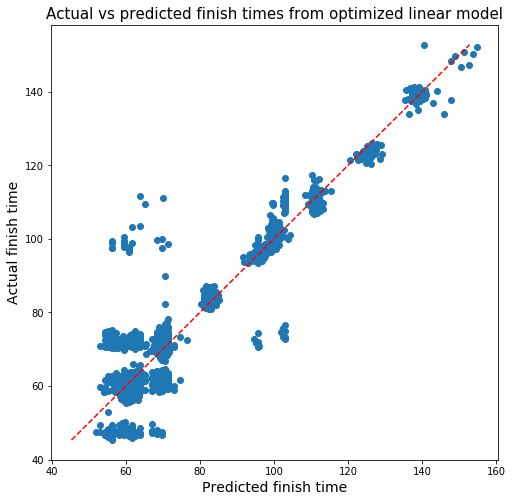

In [180]:
fig, ax = plt.subplots(1, 1, figsize = (8 ,8))
ax.scatter(test_results["Predicted finish time"], test_results["Actual finish time"])
ax.plot([min(test_results["Actual finish time"]), max(test_results["Actual finish time"])],
        [min(test_results["Actual finish time"]), max(test_results["Actual finish time"])], 
        linestyle = "--", color = "red")
ax.set_xlabel("Predicted finish time", size=14)
ax.set_ylabel("Actual finish time", size=14)
ax.set_title("Actual vs predicted finish times from optimized linear model", size = 15)